In [1]:
import numpy as np
np.set_printoptions(precision=3)  # show only 3 decimal digits

from scipy.stats import bernoulli
from scipy.signal import correlate2d

from matplotlib import animation
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from ipywidgets import interact
from copy import deepcopy
import time,cv2

# 1. Ising model

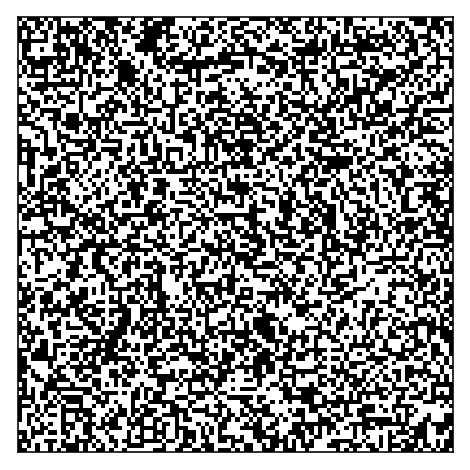

In [2]:
# Generate 100x100 array with each element contains state +1 or -1 randomly
np.random.seed(8787)
ising = np.random.choice([1,-1],p=[0.5,0.5],size=(100,100))
plt.imshow(ising,cmap="Greys")
plt.xticks([])
plt.yticks([])
plt.savefig("ising_ini.png",dpi=150,bbox_inches = 'tight')

The probability of a spin state $\sigma_n$ being $+1$ at some location $n$ is given by (McKay 2003)
$$ 
P(\sigma_n =+1|b_n)=\frac{1}{1+\exp (-2\beta b_n)}\tag{1}
$$
where $\beta=1/k_B T$ and
$$
b_n =\sum_{m\in \mathcal{N}} J \sigma_m +H \tag{2}
$$
is the contribution from $\sigma_n$'s neighbooring fields $\mathcal{N}$. The quantity $J=\{1,-1\}$ indicates the spin state at a given location prefers to be the same or different from its neighborhood and $H$ the external magnetic field. For simplicity, we take the Boltzmann constant $k_B=1$. Due to probability conservation, we can assure that $P(\sigma_n=-1|b_n)=1-P(\sigma_n=+1|b_n)$.

In [3]:
# Define Eq.(1)
def prob1(s,J=1,T=1,H=0):
    """
    Generate the probability of a spin state being +1 at
    any location when the contributions from its neighbors
    are given.
    
    Inputs
    ------
    s : The summation of the neighborhood contributions
    J : Prefers being the same or different from it's neighborhoods
    T : Temperature
    H : External field
    
    Output
    ------
    Scalar probability between 0~1.
    """
    return 1/(1+np.e**(-2*(J*s+H)/T))

In [4]:
# Deep copy a new array from the initial state for calculate final state
# Doing this for later comparision betwwen the initial and final results
ising_fin = deepcopy(ising)

In [5]:
# Given the params
J,T,H = 1,1,0
row,col = ising_fin.shape

# Calculate the contributions from the neighborhoods at every locations
nei = correlate2d(ising_fin,[[1,1,1],\
                             [1,0,1],\
                             [1,1,1]],mode="same")    

for r in range(row):
    for c in range(col):
        # Calculate the probability of jumping to +1 at loc (r,c)
        jump = prob1(nei[r,c],H=H,J=J,T=T)
        # Peforming random choice between two possible states +1 and -1,
        # although the probiblity of being at +1 is given
        ising_fin[r,c] = np.random.choice([1,-1],p=[jump,1-jump])

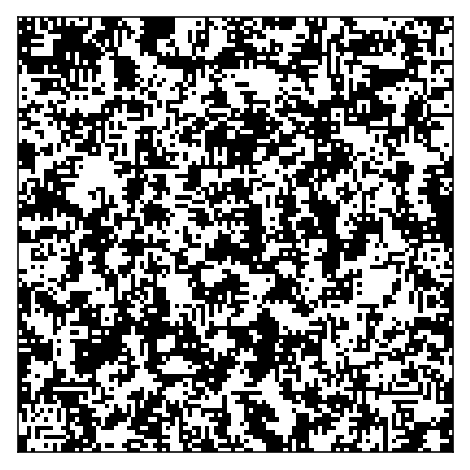

In [6]:
# Result after 1 iteration 
plt.imshow(ising_fin,cmap="Greys")
plt.xticks([])
plt.yticks([])
plt.savefig("ising_1iter.png",dpi=150,bbox_inches = 'tight')

In [7]:
# Result after 30 iterations (including the last one)  
start = time.time()
for iters in range(29):    
    nei = correlate2d(ising_fin,[[1,1,1],\
                                 [1,0,1],\
                                 [1,1,1]],mode="same")  
    for r in range(100):
        for c in range(100):
            jump = prob1(nei[r,c],H=H,J=J,T=T)
            ising_fin[r,c] = np.random.choice([1,-1],p=[jump,1-jump])
end = time.time()
print("29 iterations costs %.3f seconds."%(end-start))

29 iterations costs 5.728 seconds.


([], <a list of 0 Text yticklabel objects>)

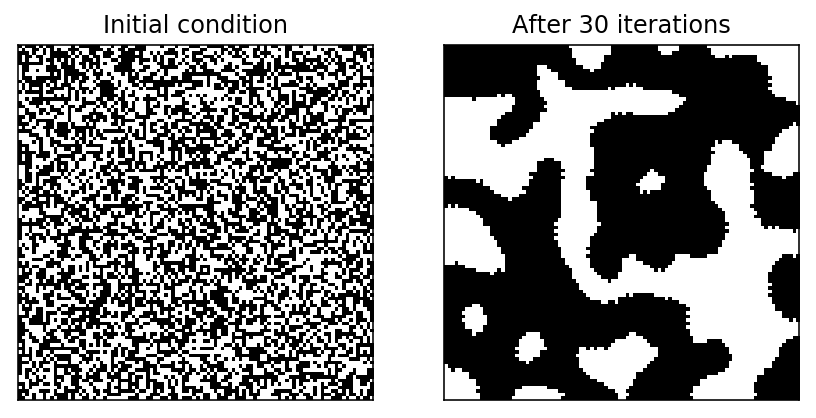

In [8]:
plt.figure(figsize=(7,3.5))

plt.subplot(121)
plt.imshow(ising,cmap="Greys")
plt.title("Initial condition")
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(ising_fin,cmap="Greys")
plt.title("After 30 iterations")
plt.xticks([])
plt.yticks([])

#plt.savefig("ising_30iter.png",dpi=150,bbox_inches = 'tight')

# 2. Ising model: A more efficient way in calculation

The previous way of calculation is correct but will be slow when the matrix size is large. Mainly due to `for` loop and `np.random.choice`. As you can see, 29 iterations costs 6.37 seconds and the matrix size is only 100×100. The performace of `np.random.choice` is not well if we want to sample with large quantity of instances.
In particluarly, it cannot samples the result of an entire Ising array simutaneously but only an array element at a time.
That's why we are forced to use `for` loop.

Our user-defeined `prob1` function is in generaly capable of generating the probability of being +1 in an array form. Let's check!

([], <a list of 0 Text yticklabel objects>)

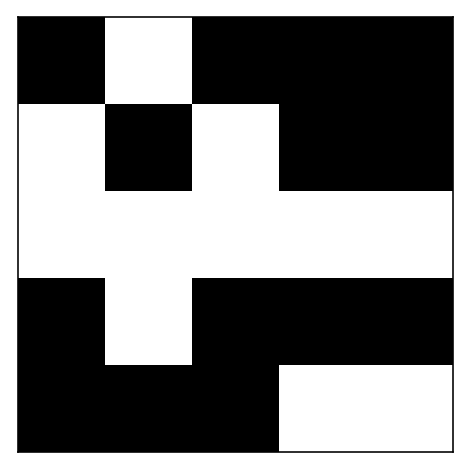

In [9]:
# Generating a small ising array for test
np.random.seed(8787)
ising_small = np.random.choice([1,-1],p=[0.5,0.5],size=(5,5))
plt.imshow(ising_small,cmap="Greys")
plt.xticks([])
plt.yticks([])

In [10]:
# The contribution from the neighbors at any location
nei_small = correlate2d(ising_small,[[1,1,1],\
                                     [1,0,1],\
                                     [1,1,1]],mode="same")

# Calculate the probability of being +1 at every location
p1 = prob1(nei_small)
print(p1)

[[1.192e-01 8.808e-01 8.808e-01 9.975e-01 9.975e-01]
 [1.192e-01 3.354e-04 5.000e-01 5.000e-01 8.808e-01]
 [1.192e-01 1.799e-02 5.000e-01 9.820e-01 9.975e-01]
 [1.192e-01 9.820e-01 1.799e-02 1.799e-02 2.473e-03]
 [8.808e-01 9.975e-01 8.808e-01 9.975e-01 8.808e-01]]


Each matrix element above indicates the probability of being +1 at that location. After finishing this iteration, the spin state will flip to +1 or -1 according to this probability matrix regardless of what spin state it is at this moment.
It's a **Markov chain** process and the possible state after this move is **_conditional on_** the current states of its neighbors.

So now we have a probability matrix, we can generate the next possible state according to this matrix. To accomplish this, we import `bernoulli` function from `scipy.stats` module. `bernoulli` takes an array-like input $p$ and option `rvs` samples betweeen {1,0} as a consequence of such pdf (please check scipy [website](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html) for further details)
$$
f(k)=\begin{cases}
1-p, & {\rm if\,}k=0;\\
p, & {\rm if}\,k=1.
\end{cases}\tag{3}
$$
For example, if $p=0.7$ then `bernoulli.rvs` generates:

In [11]:
bernoulli.rvs(p=0.7)

0

If you run more than one times, the outcomes sometimes yield 0 but all in all there is a chance of 0.7 that the outcomes are 1 and 0.3 are 0.

In [12]:
bernoulli.rvs(p=0.7, size=20)

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1])

As mentioned before, `bernoulli.rvs` also takes array-like `p`, such as `p1` above. Let's see:

In [13]:
sample = bernoulli.rvs(p=p1)
print(sample)

[[0 1 1 1 1]
 [1 0 0 0 1]
 [0 0 1 1 1]
 [0 1 0 0 0]
 [1 1 0 1 1]]


In this way, we do sample the possible spin state of each matrix element according to the probability matrix `p1`. However, we want the spin down state is −1 instead of 0. And it can be easily done by

In [14]:
sample[sample==0] = -1
print(sample)

[[-1  1  1  1  1]
 [ 1 -1 -1 -1  1]
 [-1 -1  1  1  1]
 [-1  1 -1 -1 -1]
 [ 1  1 -1  1  1]]


Now we can simply define a function called `spins` that generates the spin states by giving the probability matrix. 

In [15]:
def spins(p):
    """
    Randomly samples the spin state by giving the probability
    matrix.
    
    Input
    -----
    p : array-like probability
    
    Output
    ------
    Array with the same shape as input, each element is either +1
    or -1 that corresponds to the input. 
    """
    spin = bernoulli.rvs(p=p)
    spin[spin==0] = -1
    return spin

We can also write down a function that automatically process that does the same thing as the `for` loop in the previous section.

In [16]:
def Ising(ini,J=1,T=1,H=0):
    """
    Generate the possible next spin states according to the
    current states.
    
    Inputs
    ------
    ini : array-like, current spin states
    J : +1 for prefering to be the same state as its neighbors
        -1 for prefering to be different from its neighbors
    T : temperature
    H : external field
    
    Output
    ------
    Possible spin state according to the input. Array with the
    same shape as the input.
    """
    # Calculate the contributions from neighbors
    nei = correlate2d(ini,[[1,1,1],\
                           [1,0,1],\
                           [1,1,1]],mode="same")    
    # Calculate the probability of being +1 according to the neighborhood contributions
    p = prob1(nei,J=J,T=T,H=H)    
    # Samples the spin states according to p
    s = spins(p)    
    return s

Let's do the same calculation as the previous section

In [17]:
ising_fin2 = deepcopy(ising)

([], <a list of 0 Text yticklabel objects>)

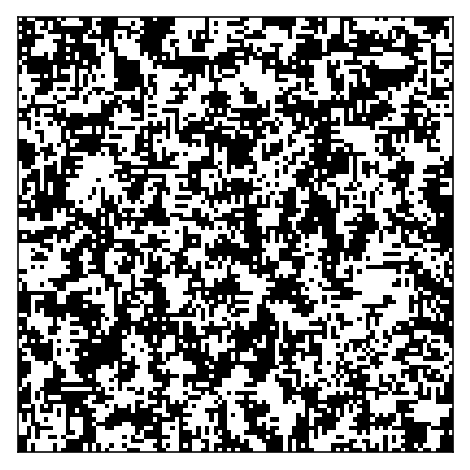

In [18]:
J,T,H = 1,1,0
ising_fin2 = Ising(ising_fin2)
plt.imshow(ising_fin2,cmap="Greys")
plt.xticks([])
plt.yticks([])

Though we have used seed random, but the sampling in `spins` by the `bernoulli.rvs` is not seeded. Thus, the result will not exactly identical to the previous section. This situation is acceptable.

Let's do more iterations and compare the time consuming with the `for` loop method. The efficiency increases in an incredible way, from more than 6 seconds reduced to 0.05 seconds. It's $\mathcal{O}(100)$ faster!

In [19]:
start = time.time()
for i in range(29):
    ising_fin2 = Ising(ising_fin2)
end = time.time()
print("29 iterations costs %.3f seconds."%(end-start))

29 iterations costs 0.051 seconds.


([], <a list of 0 Text yticklabel objects>)

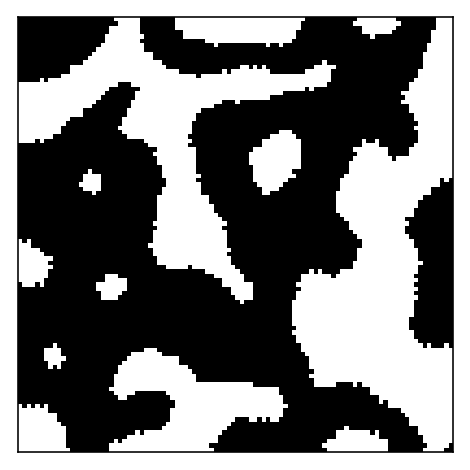

In [20]:
plt.imshow(ising_fin2,cmap="Greys")
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

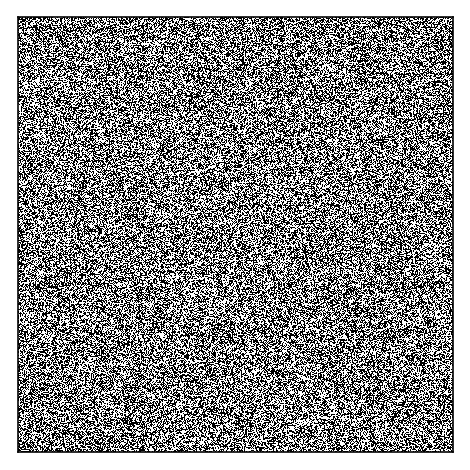

In [21]:
# Calculate with larger spin array 1000x1000
np.random.seed(8787)
ising2 = np.random.choice([1,-1],p=[0.5,0.5],size=(1000,1000))
ising_fin3 = deepcopy(ising2)
plt.imshow(ising2,cmap="Greys")
plt.xticks([])
plt.yticks([])

In [22]:
start = time.time()
for i in range(100):
    ising_fin3 = Ising(ising_fin3)
end = time.time()
print("100 iterations costs %.3f seconds."%(end-start))

100 iterations costs 14.875 seconds.


([], <a list of 0 Text yticklabel objects>)

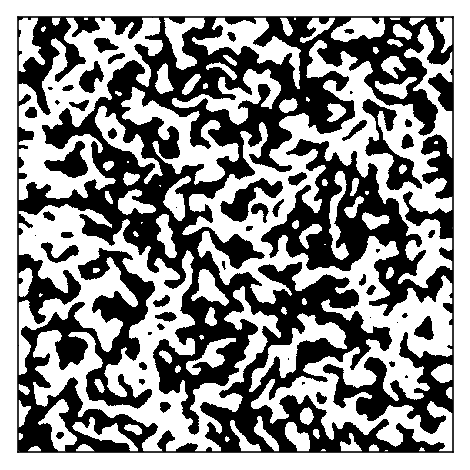

In [23]:
plt.imshow(ising_fin3,cmap="Greys")
plt.xticks([])
plt.yticks([])

# 3. Simulated annealing

In [24]:
# T changes rapidly
ann_rapi = deepcopy(ising2)
T=11
for i in range(100):
    ann_rapi = Ising(ann_rapi,T=T,H=0.1)
    if i==2: T=8
    elif i==4: T=4
    elif i==6: T=2
    elif i==7: T=1
    else: pass

In [25]:
# T changes slowly
ann_slow = deepcopy(ising2)
T = 11
for i in range(100):
    ann_slow = Ising(ann_slow,T=T,H=0.1)
    if i%10 == 0: T-=1
    else: pass

([], <a list of 0 Text yticklabel objects>)

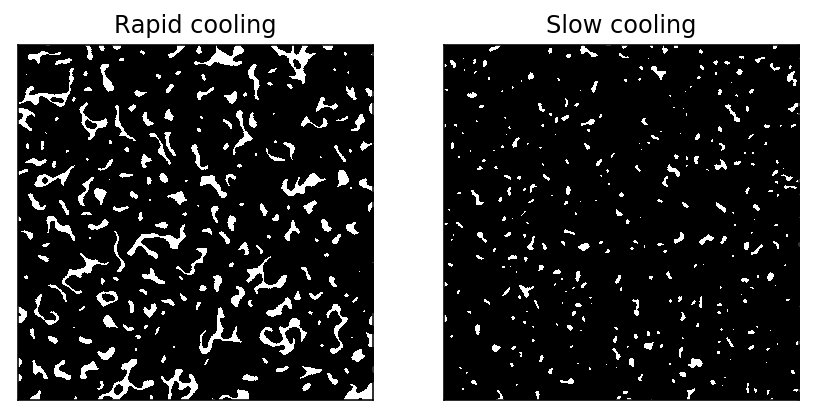

In [26]:
plt.figure(figsize=(7,3.5))

plt.subplot(121)
plt.imshow(ann_rapi,cmap="Greys")
plt.title("Rapid cooling")
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(ann_slow,cmap="Greys")
plt.title("Slow cooling")
plt.xticks([])
plt.yticks([])

#plt.savefig("ising_annealing.png",dpi=150,bbox_inches = 'tight')

## 3.1 Interactive panel via `interact` function

In [27]:
def draw_array(frame):
    plt.imshow(frame,cmap="Greys")
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def display_ising(images):
    def _show(frame=(0,len(images)-1)):
        return draw_array(images[frame])
    return interact(_show)

In [28]:
ising_seq = [ising2]
ising_ann = deepcopy(ising2)
T = 11
for i in range(100):
    ising_ann = Ising(ising_ann, H=0.1,T=T)
    ising_seq.append(ising_ann)
    if i == 2: T=10
    elif i==4: T=7
    elif i==6: T=2
    elif i==7: T=1
    else: pass

In [29]:
display_ising(ising_seq)

interactive(children=(IntSlider(value=50, description='frame'), Output()), _dom_classes=('widget-interact',))

<function __main__.display_ising.<locals>._show(frame=(0, 100))>

## 3.2 Artificial initial conditions

In [30]:
def binarize(img, th=140):
    """
    Binarize a grey image.
    im: Grey 2D image with pixel value in (0,255)
    th: thereshold value, pixel value greater than th sets 1 and lower sets -1
    
    Return: binarized image
    """
    im = deepcopy(img)
    im[img>=th] = -1
    im[img<th] = 1
    return im.astype(np.int8)

In [31]:
# Checkerboard pattern
ising_check = np.kron([[1, -1] * 4, [-1, 1] * 4] * 4, np.ones((100, 100)))
# Garfield pattern
ising_garfield = binarize(cv2.imread("images/garfield.jpg", 0))

### 3.2.1 Checkerboard pattern

In [32]:
# T changes rapidly
check_rapi = deepcopy(ising_check)
T=11
for i in range(30):
    if i == 3: T=3
    elif i == 5: T=1
    else: pass
    check_rapi = Ising(check_rapi,T=T,H=0)

In [33]:
# T changes slowly
check_slow = deepcopy(ising_check)
T = 11
for i in range(99):
    check_slow = Ising(check_slow,T=T,H=0)
    if i%10 == 0: T-=1
    else: pass

([], <a list of 0 Text yticklabel objects>)

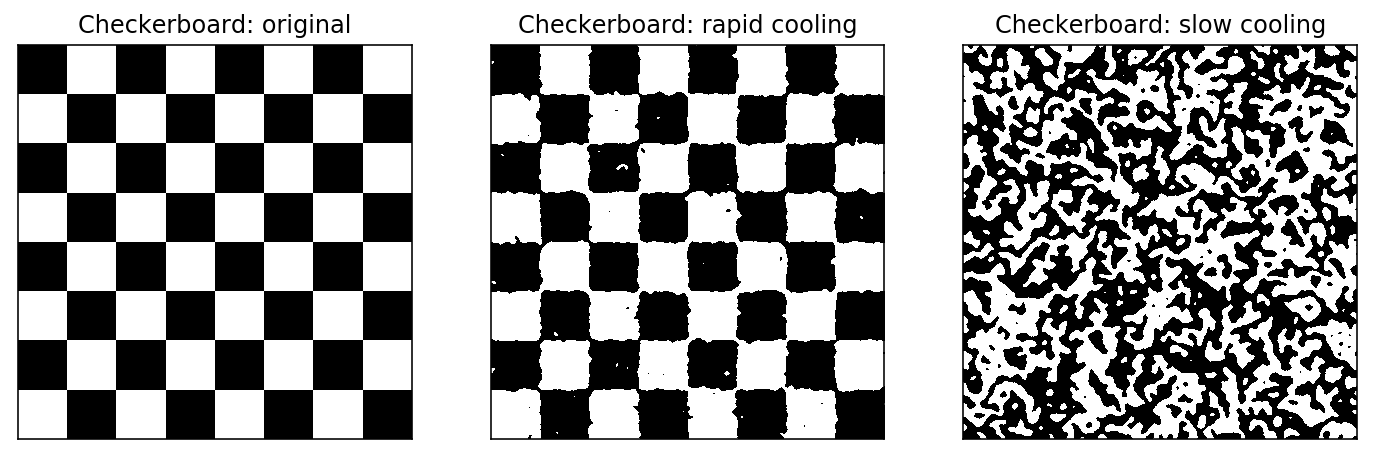

In [34]:
plt.figure(figsize=(12,4))

plt.subplot(131)
plt.imshow(ising_check,cmap="Greys")
plt.title("Checkerboard: original")
plt.xticks([])
plt.yticks([])

plt.subplot(132)
plt.imshow(check_rapi,cmap="Greys")
plt.title("Checkerboard: rapid cooling")
plt.xticks([])
plt.yticks([])

plt.subplot(133)
plt.imshow(check_slow,cmap="Greys")
plt.title("Checkerboard: slow cooling")
plt.xticks([])
plt.yticks([])

#plt.savefig("check.png",dpi=150,bbox_inches = 'tight')

### 3.2.2 Garfield pattern

In [35]:
# T changes rapidly
gar_rapi = deepcopy(ising_garfield)
gar_ann_rapi = [gar_rapi]
T=11
for i in range(30):
    if i == 3: T=3
    elif i == 5: T=1
    else: pass
    gar_rapi = Ising(gar_rapi,T=T,H=0)
    gar_ann_rapi.append(gar_rapi)

In [36]:
# T changes slowly
gar_slow = deepcopy(ising_garfield)
gar_ann_slow = [gar_slow]
T = 11
for i in range(99):
    gar_slow = Ising(gar_slow,T=T,H=0)
    gar_ann_slow.append(gar_slow)
    if i%10 == 0: T-=1
    else: pass

([], <a list of 0 Text yticklabel objects>)

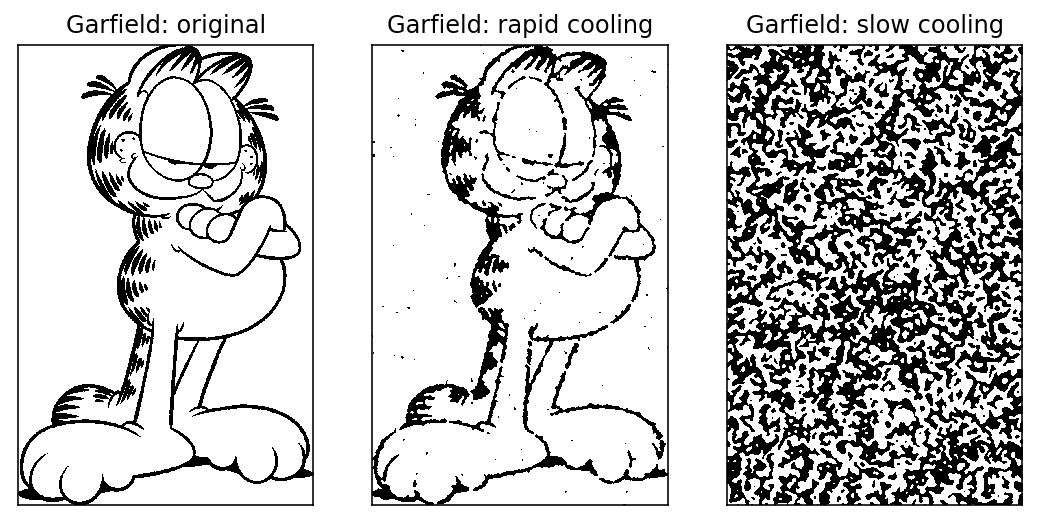

In [37]:
plt.figure(figsize=(9,6))
           
plt.subplot(131)
plt.imshow(ising_garfield,cmap="Greys")
plt.title("Garfield: original")
plt.xticks([])
plt.yticks([])

plt.subplot(132)
plt.imshow(gar_rapi,cmap="Greys")
plt.title("Garfield: rapid cooling")
plt.xticks([])
plt.yticks([])

plt.subplot(133)
plt.imshow(gar_slow,cmap="Greys")
plt.title("Garfield: slow cooling")
plt.xticks([])
plt.yticks([])

#plt.savefig("garfield.png",dpi=150,bbox_inches = 'tight')

In [38]:
display_ising(gar_ann_rapi)

interactive(children=(IntSlider(value=15, description='frame', max=30), Output()), _dom_classes=('widget-inter…

<function __main__.display_ising.<locals>._show(frame=(0, 30))>

In [39]:
display_ising(gar_ann_slow)

interactive(children=(IntSlider(value=49, description='frame', max=99), Output()), _dom_classes=('widget-inter…

<function __main__.display_ising.<locals>._show(frame=(0, 99))>